In [103]:
import os
import cv2
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, random_split

warnings.filterwarnings("ignore")

# Смотрим фичи классификации

## Модель

In [104]:
class BaseCNN(nn.Module):
    def __init__(self, input_size=24):
        super(BaseCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flattened_size = (input_size // 4) * (input_size // 4) * 16

        self.fc = nn.Linear(self.flattened_size, 2)

    def forward(self, x, return_features=False):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        features = x.view(x.size(0), -1)
        out = self.fc(features)

        if return_features:
            return out, features
        return out

In [105]:
model = BaseCNN(input_size=36)
dummy_input = torch.randn(8, 1, 36, 36)

logits, features = model(dummy_input, return_features=True)

print("Logits shape:", logits.shape)  # [8, 2]
print("Features shape:", features.shape)  # [8, N]

Logits shape: torch.Size([8, 2])
Features shape: torch.Size([8, 1296])


## Аннотирование

Функция для действий при нажатии на клавиши мыши

In [106]:
def click_event(event, x, y, flags, params):
    global data

    # Ручной способ задания прямоугольника для дальнейшего сжатия

    # if event == cv2.EVENT_LBUTTONDOWN:
    #     new_row = pd.Series({'x1': x, 'y1': y, 'x2': None, 'y2': None, 'label': None})
    #     data = pd.concat([data, new_row.to_frame().T], ignore_index=True)
    #     print(f'ЛКМ: добавил точку ({x},{y}) как x1, y1')
    # 
    # elif event == cv2.EVENT_RBUTTONDOWN:
    #     idx = data[data['x2'].isnull()].last_valid_index()
    #     if idx is not None:
    #         data.at[idx, 'x2'] = x
    #         data.at[idx, 'y2'] = y
    #         print(f'ПКМ: добавил точку ({x},{y}) как x2, y2')

    if event == cv2.EVENT_LBUTTONDOWN:
        x1, y1 = x - 18, y - 18
        x2, y2 = x + 18, y + 18

        new_row = pd.Series({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'label': None})
        data = pd.concat([data, new_row.to_frame().T], ignore_index=True)
        print(f'ЛКМ: добавил прямоугольник ({x},{y}) как x1, y1')

Функция для действий при нажатии на кнопку

In [107]:
def key_event():
    global data
    while True:
        key = cv2.waitKey(0) & 0xFF
        idx = data[data['label'].isnull()].last_valid_index()

        if key == ord('w') and idx is not None:
            data.at[idx, 'label'] = 1
            print('label = 1')
        elif key == ord('s') and idx is not None:
            data.at[idx, 'label'] = 0
            print('label = 0')
        elif key == ord('t'):
            save_patches()
            return 'continue'
        elif key == ord('q'):
            save_all_tensors()
            return 'end'

Функция для сохранения патчей

In [108]:
def save_patches():
    global current_img, data, all_tensors, all_labels, all_images

    for i, row in data.iterrows():
        if pd.isnull(row[['x1', 'y1', 'x2', 'y2', 'label']]).any():
            continue

        x1, y1, x2, y2 = map(int, [row['x1'], row['y1'], row['x2'], row['y2']])
        xmin, xmax = min(x1, x2), max(x1, x2)
        ymin, ymax = min(y1, y2), max(y1, y2)

        patch = current_img[ymin:ymax, xmin:xmax]
        patch_gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        # patch_resized = cv2.resize(patch_gray, (36, 36))
        patch_resized = patch_gray
        
        
        # TODO надо потестить
        patch_resized = cv2.adaptiveThreshold(
            patch_resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )

        patch_tensor = torch.tensor(patch_resized, dtype=torch.float32).unsqueeze(0)

        # patch_tensor /= 255.0

        all_tensors.append(patch_tensor)
        all_labels.append(int(row["label"]))
        all_images.append(patch_resized)

    data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'label'])

Функция для сохранения финальных тензоров

In [109]:
def save_all_tensors():
    global all_tensors, all_labels
    try:
        all_tensors_tensor = torch.stack(all_tensors)
        torch.save(all_tensors_tensor, 'CV_data/Train/images.pt')
        torch.save(all_labels, 'CV_data/Train/labels.pt')
        print(f'Сохранены все тензоры и лейблы {len(all_labels)}')

        for i, image in enumerate(all_images):
            cv2.imwrite(f'CV_data/Train/Images/image_{i}.jpg', image)

    except Exception as e:
        print(e)
        print('Данные не были сохранены')

In [111]:
data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'label'])

photo_dir = 'CV_data/photos'
photos = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]

output_dir = 'CV_data/Train'
os.makedirs(output_dir, exist_ok=True)

current_img = None

all_tensors = []
all_labels = []
all_images = []

for photo in photos:
    current_img = cv2.imread(photo)
    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame', current_img)

    cv2.setMouseCallback('frame', click_event)
    res = key_event()

    cv2.destroyAllWindows()

    if res == 'end':
        break

ЛКМ: добавил прямоугольник (902,925) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (845,1000) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (816,1069) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (868,1115) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (976,1147) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1162,1141) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1236,1043) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1305,957) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1338,1115) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1371,1158) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1422,1161) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1596,1190) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1678,1213) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1732,1167) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1788,1104) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1829,1161) как x1, y1
label = 0
ЛКМ: добавил прямоугольник (1845,1253) как x1, 

## Обучение

Функция обучения

In [24]:
def train(
        model: nn.Module,
        data_loader: DataLoader,
        optimizer: Optimizer,
        loss_fn,
        device: torch.device,
) -> tuple[float, float]:
    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

Функция для валидации

In [25]:
@torch.inference_mode()
def evaluate(
        model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Evaluate"):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

Функция для вывода статистики

In [26]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " accuracy")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()

    plt.show()

Функция для цикла обучения и валидации

In [27]:
def whole_train_valid_cycle(
        model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        scheduler.step()

        if valid_accuracy >= threshold:
            break

Запуск обучения

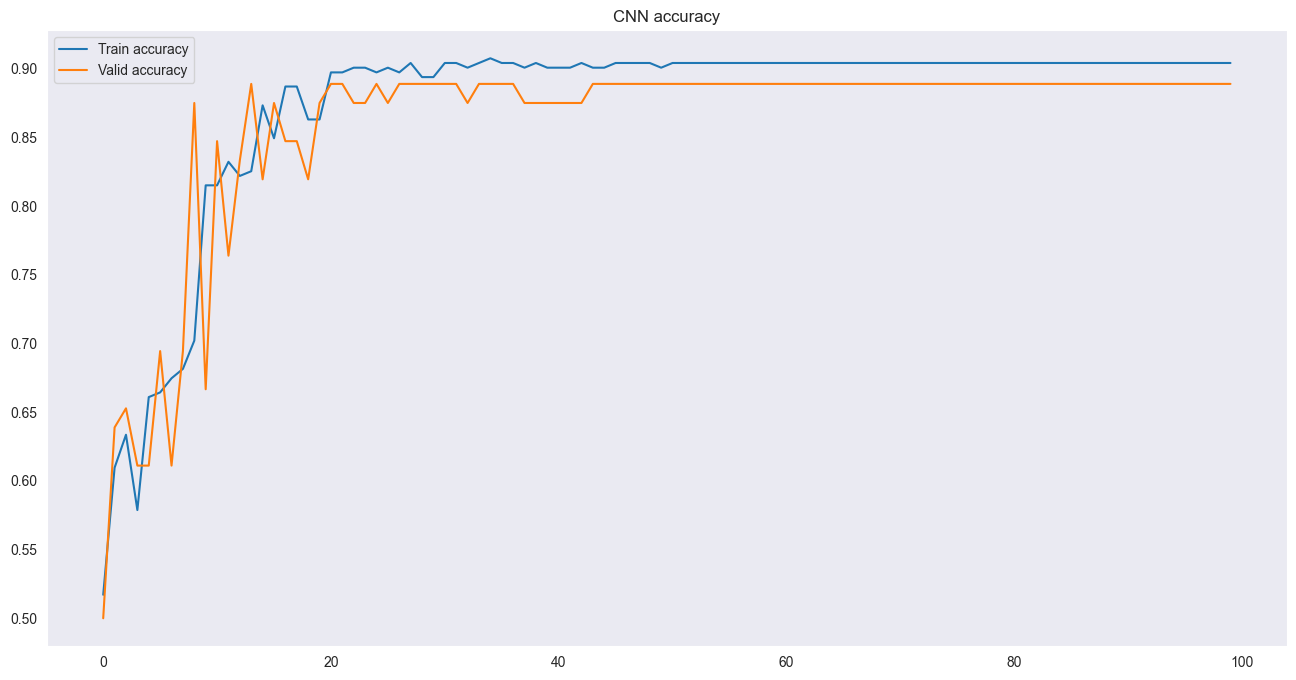

In [81]:
images = torch.load('CV_data/Train/images.pt')
labels = torch.load('CV_data/Train/labels.pt')

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

full_dataset = TensorDataset(images, labels)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

model = BaseCNN(input_size=36).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold=1, title='CNN'
)

torch.save(model.state_dict(), "CV_data/model.pt")

## Инференс тест

In [98]:
images = torch.load('CV_data/Train/images.pt')
labels = torch.load('CV_data/Train/labels.pt')

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

full_dataset = TensorDataset(images, labels)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

_, val_dataset = random_split(full_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

model = BaseCNN(input_size=36).to(device)
model.load_state_dict(torch.load('CV_data/model.pt'))
model.eval()

all_logits = []
all_preds = []
all_labels = []
all_features = []

with torch.no_grad():
    for batch_imgs, batch_labels in val_loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        logits, features = model(batch_imgs, return_features=True)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

        all_logits.append(logits.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(batch_labels.cpu())
        all_features.append(features.cpu())

all_logits = torch.cat(all_logits)
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_features = torch.cat(all_features)

print(f'Accuracy - {round((all_preds == all_labels).float().mean().item(), 2)}')

Accuracy - 0.82


Посмотрим на фичи

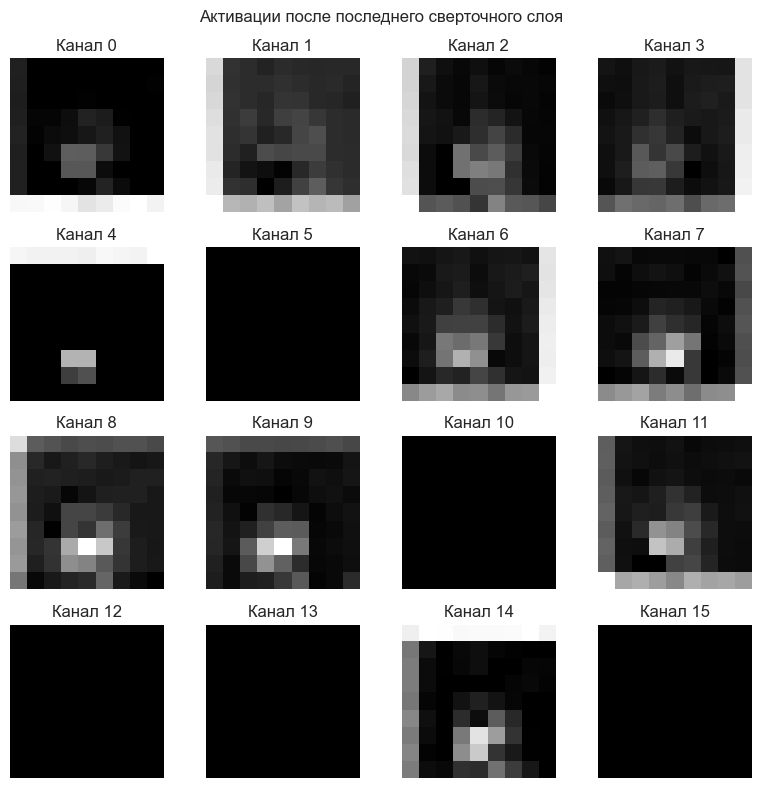

In [100]:
images = torch.load('CV_data/Train/images.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img = images[3].unsqueeze(0).to(device)

model = BaseCNN(input_size=36).to(device)
model.load_state_dict(torch.load('CV_data/model.pt'))
model.eval()

with torch.no_grad():
    x = model.relu(model.conv1(img))
    x = model.pool(x)
    x = model.relu(model.conv2(x))
    features = model.pool(x)

features = features.squeeze(0).cpu()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[i], cmap='gray')
    ax.set_title(f'Канал {i}')
    ax.axis('off')

plt.suptitle('Активации после последнего сверточного слоя')
plt.tight_layout()
plt.show()

## Инференс прод

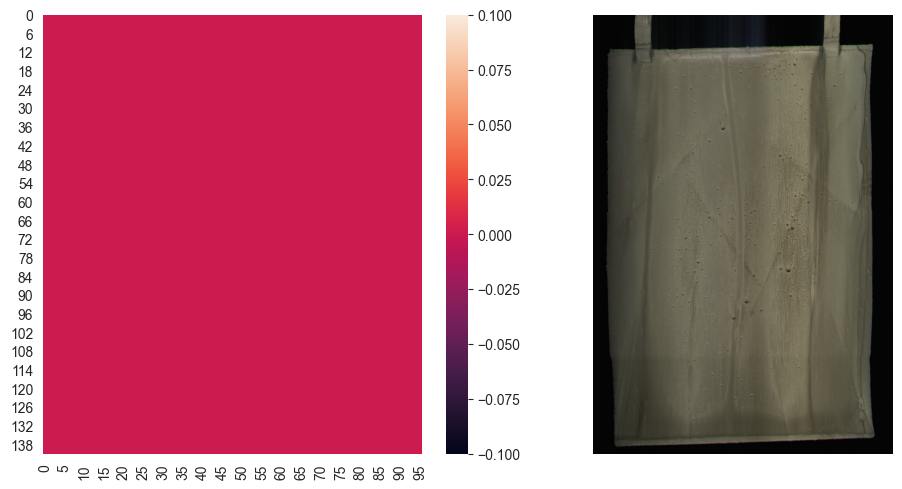

In [102]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import math
import seaborn as sns

# img_path = "CV_data/photos/1742453837_4_bottom.jpg"
img_path = "img.png"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaseCNN(input_size=36).to(device)
model.load_state_dict(torch.load('CV_data/model.pt'))
model.eval()

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_np = np.array(image)

transform = transforms.Compose([
    transforms.ToTensor(),
])

stride = 18
window_size = 36
arr = np.zeros((math.floor((image_np.shape[0] - window_size) / stride) + 1,
                math.floor((image_np.shape[1] - window_size) / stride) + 1))

positive_images = []

for i, y in enumerate(range(0, image_np.shape[0] - window_size + 1, stride)):
    for j, x in enumerate(range(0, image_np.shape[1] - window_size + 1, stride)):
        patch = image_np[y:y + window_size, x:x + window_size]
        patch_tensor = transform(patch).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(patch_tensor)
            pred = torch.argmax(output, dim=1).item()

        if pred:
            positive_images.append(patch)

        arr[i, j] = pred

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(arr, ax=ax[0])

ax[1].imshow(plt.imread(img_path))
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [78]:
positive_images

[]

In [72]:
cv2.imshow('za',patch)
cv2.waitKey(0)

-1

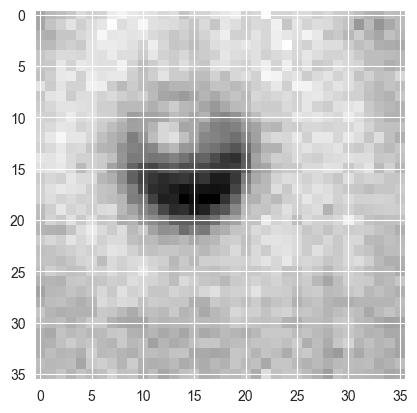

In [159]:
plt.imshow(positive_images[-2], cmap='gray')

# Пробуем определять высоту

In [17]:
file_path = '192.168.25.105_1710930733.txt'
points = []
z_array = []
with open(file_path, 'r') as file:
    for x, line in enumerate(file):
        z_array.append([])
        numbers = line.strip().split()

        for i in range(0, len(numbers), 2):
            if i + 1 < len(numbers):
                y = float(numbers[i])
                z = float(numbers[i + 1])
                points.append([x, y, z])

                z_array[x].append(z)

points = pd.DataFrame(points, columns=['X', 'Y', 'Z'])
points

,X,Y,Z
0,0,-432.0,33.3086
1,0,-431.0,33.8227
2,0,-430.0,34.3368
3,0,-429.0,34.6860
4,0,-428.0,34.8994
...,...,...,...
1365085,1494,492.0,77.7831
1365086,1494,493.0,77.4145
1365087,1494,494.0,77.1235
1365088,1494,495.0,76.8422


In [18]:
import torch
import numpy as np
from torchvision import transforms
import math
import seaborn as sns

img_path = "img.png"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaseCNN(input_size=36).to(device)
model.load_state_dict(torch.load('CV_data/model.pt'))
model.eval()

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_np = np.array(image)

transform = transforms.Compose([
    transforms.ToTensor(),
])

stride = 12
window_size = 36
arr = np.zeros((math.floor((image_np.shape[0] - window_size) / stride) + 1,
                math.floor((image_np.shape[1] - window_size) / stride) + 1))

positive_images = []

for i, y in enumerate(range(0, image_np.shape[0] - window_size + 1, stride)):
    for j, x in enumerate(range(0, image_np.shape[1] - window_size + 1, stride)):
        patch = image_np[y:y + window_size, x:x + window_size]
        patch_tensor = transform(patch).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(patch_tensor)
            pred = torch.argmax(output, dim=1).item()

        if pred:
            positive_images.append(patch)

        arr[i, j] = pred

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(arr, ax=ax[0])

ax[1].imshow(plt.imread(img_path))
ax[1].axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'CV_data/model.pt'

# Z

In [1]:
import cv2

image = cv2.imread('CV_data/photos/1742453912_H1_top.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image_thresh = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 11, 2
)
cv2.imshow('image', image_thresh)
cv2.waitKey(0)

113